#Come classificare le immagini satellitari

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
results_path = Path ('results', 'eurosat')
if not results_path.exists():
    results_path.mkdir(parents=True)

#Carichiamo il datset EuroSat

In [5]:
(raw_train, raw_validation), metadata = tfds.load('eurosat',
                                                  split=[
                                                      'train[:90%]',
                                                      'train[90%:]'
                                                  ],
                                                  with_info=True,
                                                  shuffle_files=False,
                                                  as_supervised=True,
                                                  data_dir='../data/tensorflow')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling ../data/tensorflow/eurosat/rgb/2.0.0.incomplete7YSTY2/eurosat-train.tfrecord*...:   0%|          | 0…

Dataset eurosat downloaded and prepared to ../data/tensorflow/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [6]:
#isepzioniamo i metadati
metadata

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path=PosixGPath('/tmp/tmpexh1ku7ztfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('im

In [7]:
print('Train:\t', raw_train)
print('Valid:\t', raw_validation)

Train:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Valid:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


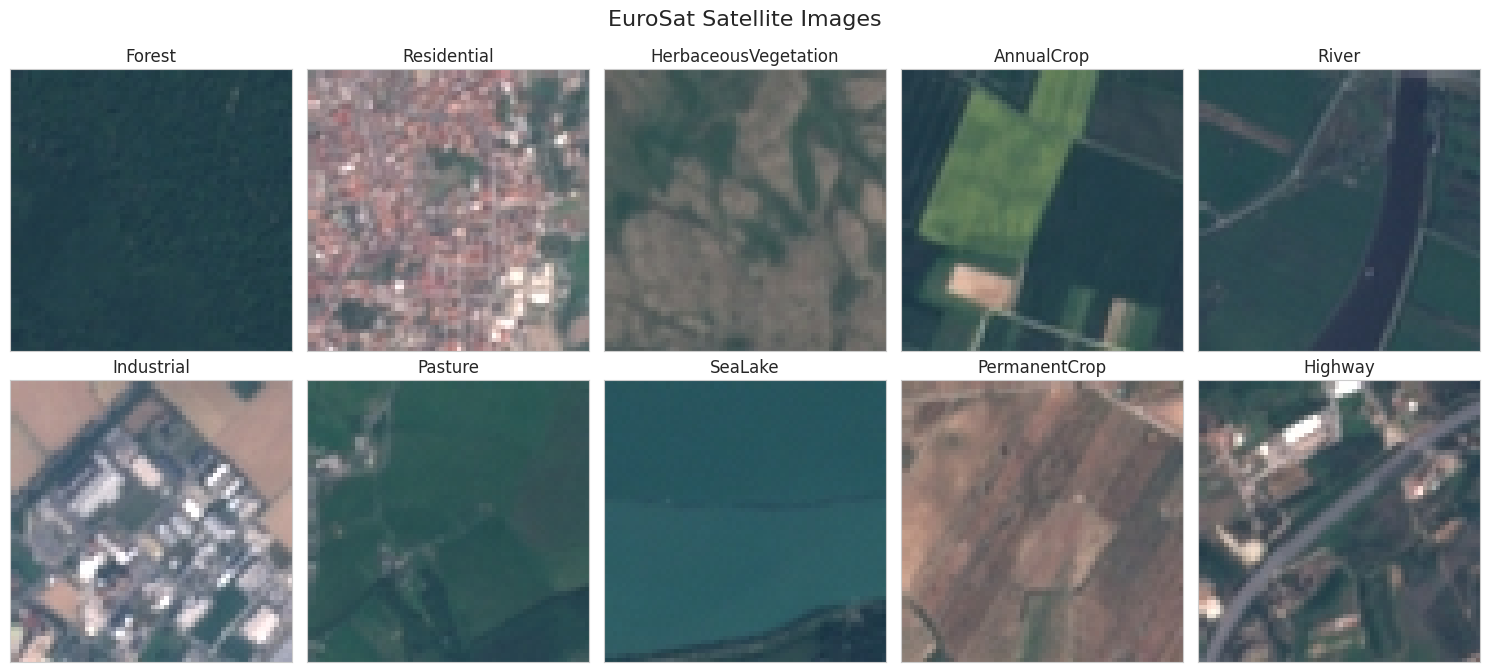

In [8]:
#mostriamo immagini campione
fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
axes = axes.flatten()
get_label_name = metadata.features['label'].int2str
labels = set()
c = 0
for img, label in raw_train.as_numpy_iterator():
    if label not in labels:
        axes[c].imshow(img)
        axes[c].set_title(get_label_name(label))
        axes[c].grid(False)
        axes[c].tick_params(axis='both', 
                            which='both', 
                            bottom=False, 
                            top=False, 
                            labelbottom=False, 
                            right=False, 
                            left=False, 
                            labelleft=False)
        labels.add(label)
        c += 1
        if c == 10:
            break
fig.suptitle('EuroSat Satellite Images', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.92);
# fig.savefig(results_path / 'eurosat_samples', dpi=300);

#Pre-elaborazione

Tutte le immagini devono essere ridimensionate a 160x160

In [9]:
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [10]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [13]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [14]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 64, 64, 3])

#Carichiamo le caratteristiche collo di bottiglia di DenseNet201

In [15]:
densenet = DenseNet201(input_shape=IMG_SHAPE, 
                       include_top=False, 
                       weights='imagenet',
                       pooling='max',
                       classes=1000)

densenet.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                       

In [16]:
feature_batch = densenet(image_batch)
feature_batch.shape

TensorShape([32, 1920])

In [17]:
len(densenet.layers)

708

#Aggiungiamo nuovi strati al modello

In [18]:
model = Sequential([
    densenet,
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

In [19]:
for layer in model.layers:
    layer.trainable = True

In [20]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              3934208   
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8

In [22]:
initial_epochs = 10
validation_steps = 20

initial_loss, initial_accuracy = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 20s 624ms/step - loss: 3256.1899 - accuracy: 0.1187


In [23]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 3256.19 | initial_accuracy accuracy: 11.87%


#Addestriamo il modello

In [24]:
#definiamo le callbacks

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10)

In [25]:
eurosat_path = (results_path / 'cnn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=eurosat_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [26]:
epochs = 100

In [ ]:
history = model.fit(train_batches,
                    epochs=epochs,
                    validation_data=validation_batches,
                    callbacks=[checkpointer, 
                               early_stopping])

Epoch 1/100
287/760 [==========>...................] - ETA: 29:35 - loss: 1687.7025 - accuracy: 0.7770

In [ ]:
#plot learning curves
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['accuracy', 'val_accuracy']].plot(ax=axes[0], title='Accuracy')
    df[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    fig.tight_layout();

metrics = pd.DataFrame(history.history)
metrics.index = metrics.index.to_series().add(1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics[['accuracy', 'val_accuracy']].plot(ax=axes[0], 
                                           title=f'Accuracy (Best: {metrics.val_accuracy.max():.2%})')
axes[0].axvline(metrics.val_accuracy.idxmax(), ls='--', lw=1, c='k')
metrics[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy', logy=True)
for ax in axes:
    ax.legend(['Training', 'Validation'])
    ax.set_xlabel('Epoch')
    
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'satellite_accuracy', dpi=300);